<a href="https://colab.research.google.com/github/zey-o/DeepLearning_Wikiart_Emotions/blob/main/7b_three_classes_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
import numpy as np

import pathlib
import matplotlib.pyplot as plt

from glob import glob
# import os
from google.colab import files

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, Activation, LeakyReLU
from tensorflow.keras import regularizers

from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import InputLayer


Again the same procedure: 
We'll first load the datasets as well as the images. For this '3-class' model, we will be trying to predict whether an artwork evokes 'positive', 'negative' or 'mixed' images as attributed by the authors of the study. 
1. Check & Load Data: We will first set the parameters of the modeling that we will be doing. 
2. Modeling: In this section we will try out a baseline model and then do transfer learning and data augmentation to come up with a final model. 
3. Predictions: Predict classes & check with the images assigned the predictions. 

## Check & Load Data from Directory

In [7]:
data_dir = pathlib.Path("drive/MyDrive/DL/dataset_images")

In [8]:
image_count = len(list(data_dir.glob('**/*.png')))
print(image_count)

4119


In [9]:
df = pd.read_csv("drive/MyDrive/DL/path_prob.csv")

In [10]:
df.head(3)

Unnamed: 0  ...                                         path
0           0  ...  dataset_images/58c6237dedc2c9c7dc0de1ae.png
1           1  ...  dataset_images/577280dfedc2cb3880f28e76.png
2           2  ...  dataset_images/57727f2dedc2cb3880ed5fa9.png

[3 rows x 4 columns]

In [11]:
df.path = "drive/MyDrive/DL/" + df.path
df.head(3)

Unnamed: 0  ...                                               path
0           0  ...  drive/MyDrive/DL/dataset_images/58c6237dedc2c9...
1           1  ...  drive/MyDrive/DL/dataset_images/577280dfedc2cb...
2           2  ...  drive/MyDrive/DL/dataset_images/57727f2dedc2cb...

[3 rows x 4 columns]

In [12]:
df.emotion.value_counts()

happiness           1102
surprise             822
anticipation         520
trust                478
fear                 358
sadness              226
humility             184
love                 114
disgust              101
optimism              62
arrogance             52
anger                 36
gratitude             14
pessimism             10
shame                  7
disagreeableness       7
neutral                5
agreeableness          5
shyness                2
Name: emotion, dtype: int64

For this 3-classes problem, we will tackle with identifying positive, negative & mixed emotions as per the description given by the authors of this study. 

In [13]:
positive_emotions = ['gratitude', 'happiness', 'humility', 'love', 'optimism', 'trust']
negative_emotions = ['anger', 'arrogance', 'disgust', 'fear', 'pessimism', 'regret', 'sadness', 'shame']
mixed_emotions = ['agreeableness', 'anticipation', 'disagreeableness', 'shyness', 'surprise', 'neutral']

In [14]:
df["emotion"] = df.emotion.apply(lambda x: "positive" if (x in positive_emotions) \
                                 else ("negative" if x in negative_emotions else "mixed"))
df.head(5)

Unnamed: 0  ...                                               path
0           0  ...  drive/MyDrive/DL/dataset_images/58c6237dedc2c9...
1           1  ...  drive/MyDrive/DL/dataset_images/577280dfedc2cb...
2           2  ...  drive/MyDrive/DL/dataset_images/57727f2dedc2cb...
3           3  ...  drive/MyDrive/DL/dataset_images/58d1240cedc2c9...
4           4  ...  drive/MyDrive/DL/dataset_images/57727de7edc2cb...

[5 rows x 4 columns]

In [15]:
df.emotion.value_counts()

positive    1954
mixed       1361
negative     790
Name: emotion, dtype: int64

In [16]:
image_count = len(df)
image_count

4105

### Set parameters

Let's set some of the parameters we will be using. 

- The image size we will resize all images to at the beginning of our training process. 
- We will set the number of epochs to a certain number so that we can keep tweaking it later. 
- Batch size will be 32. 
- The emotions we will be working with. 
- We will split the data into 3: train - validation - test (60% - 20% - 20%) 

In [17]:
img_height = 180
img_width = 180

In [18]:
epochs = 100
batch_size = 32

In [19]:
val_set_start = int((6)*image_count//10)
test_set_start = int(8*image_count//10)

In [20]:
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = "emotion",
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        seed = 42,
                                        shuffle = True,
                                        class_mode = "categorical",
                                        target_size = (img_height, img_width))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            # # interpolation = 'bilinear',
                                            # seed = 42,
                                            shuffle = False,
                                            class_mode = "categorical",
                                            target_size = (img_height, img_width))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "categorical",
                                            target_size = (img_height, img_width))

Found 2463 validated image filenames belonging to 3 classes.
Found 821 validated image filenames belonging to 3 classes.
Found 821 validated image filenames belonging to 3 classes.


In [21]:
class_names = train_generator.class_indices
print(class_names)

{'mixed': 0, 'negative': 1, 'positive': 2}


In [22]:
num_classes = len(class_names)
num_classes

3

In [23]:
images, labels = next(train_generator)
print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

float32 (32, 180, 180, 3)
float32 (32, 3)


In [24]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

## Rebuild Model 

In [25]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = "emotion",
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        # seed = 42,
                                        shuffle = True,
                                        class_mode = "categorical",
                                        target_size = (224, 224))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            # seed = 42,
                                            shuffle = False,
                                            class_mode = "categorical",
                                            target_size = (224, 224))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            # seed = 42,
                                            shuffle = False,
                                            class_mode = "categorical",
                                            target_size = (224, 224))

Found 2463 validated image filenames belonging to 3 classes.
Found 821 validated image filenames belonging to 3 classes.
Found 821 validated image filenames belonging to 3 classes.


In [26]:
base_model = mobilenet_v2.MobileNetV2\
                (weights='imagenet', include_top=False, input_shape=(224, 224,3)) 

for layer in base_model.layers:
    layer.trainable = False   

x = base_model.output
x = Flatten()(x) 
x = Dense(512, activation='relu')(x) 
x = Dense(50, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x) 

model_tc_mobilenet_aug = Model(inputs=base_model.input, outputs=predictions)
model_tc_mobilenet_aug.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model_tc_mobilenet_aug.summary()

9420800/9406464 [==============================] - 0s 0us/step


In [27]:
class_weights = {0: 1.,
                1: 1.,
                2: 2.}

history_tc_mobilenet_aug = model_tc_mobilenet_aug.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = EarlyStopping(monitor='val_loss', \
                                              mode='min', verbose=1, patience = 20,\
                                             restore_best_weights=True), 
                    class_weight = class_weights
)

Epoch 1/100
76/76 [==============================] - 1141s 15s/step - loss: 8.3240 - accuracy: 0.5409 - val_loss: 3.4306 - val_accuracy: 0.5075
Epoch 2/100
76/76 [==============================] - 116s 2s/step - loss: 3.5904 - accuracy: 0.5882 - val_loss: 3.0021 - val_accuracy: 0.5888
Epoch 3/100
76/76 [==============================] - 115s 2s/step - loss: 2.7565 - accuracy: 0.6347 - val_loss: 4.7322 - val_accuracy: 0.5038
Epoch 4/100
76/76 [==============================] - 116s 2s/step - loss: 2.0067 - accuracy: 0.6384 - val_loss: 2.6199 - val_accuracy: 0.5925
Epoch 5/100
76/76 [==============================] - 115s 2s/step - loss: 1.4405 - accuracy: 0.6656 - val_loss: 2.6917 - val_accuracy: 0.5450
Epoch 6/100
76/76 [==============================] - 114s 1s/step - loss: 1.1723 - accuracy: 0.6923 - val_loss: 1.8165 - val_accuracy: 0.6062
Epoch 7/100
76/76 [==============================] - 113s 1s/step - loss: 1.0603 - accuracy: 0.6915 - val_loss: 1.3563 - val_accuracy: 0.6187
Epoc

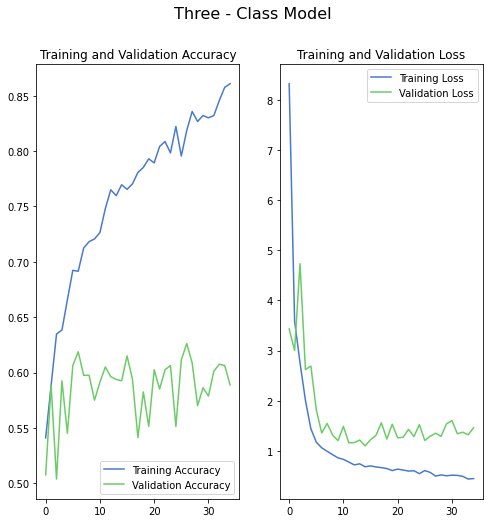

In [28]:
number_of_epochs_it_ran = len(history_tc_mobilenet_aug.history['loss'])

acc = history_tc_mobilenet_aug.history['accuracy']
val_acc = history_tc_mobilenet_aug.history['val_accuracy']

loss = history_tc_mobilenet_aug.history['loss']
val_loss = history_tc_mobilenet_aug.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.style.use("seaborn-muted")
acc_plot = plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

acc_plot.suptitle('Three - Class Model', fontsize=16)
acc_plot.show()

## Prediction & Evaluations

In [29]:
# import libraries for prediction/ evaluation & visualization
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, precision_recall_curve, roc_curve, roc_auc_score, f1_score

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.utils import load_img, img_to_array
from tensorflow import expand_dims
from tensorflow.keras.models import load_model

### Predict

In [30]:
# model_tc_mobilenet_aug = load_model('drive/MyDrive/DL/model_three_classes.h5')

In [31]:
predictions = model_tc_mobilenet_aug.predict(test_generator)

In [32]:
class_names = test_generator.class_indices
print(class_names)
class_names_list = list(class_names.keys())

{'mixed': 0, 'negative': 1, 'positive': 2}


In [33]:
print(predictions[15])
print(np.argmax(predictions[15]))

[0.83527863 0.02046332 0.144258  ]
0


In [34]:
predicted_class_indices=np.argmax(predictions,axis = 1)
y_ground_truth = test_generator.labels

In [35]:
print(y_ground_truth)

[0, 0, 2, 2, 1, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 1, 0, 2, 2, 0, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 2, 1, 2, 0, 2, 0, 1, 2, 0, 2, 2, 1, 2, 1, 0, 2, 0, 0, 0, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 1, 0, 0, 2, 0, 1, 2, 2, 0, 2, 0, 0, 0, 1, 2, 0, 2, 1, 0, 2, 2, 0, 0, 0, 0, 0, 2, 1, 0, 2, 2, 0, 1, 2, 0, 2, 2, 2, 1, 2, 0, 2, 2, 0, 1, 0, 2, 0, 1, 0, 1, 2, 2, 2, 0, 0, 0, 2, 1, 1, 0, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 1, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 1, 0, 1, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 1, 0, 2, 0, 2, 2, 2, 1, 0, 0, 1, 2, 2, 2, 0, 0, 2, 1, 2, 2, 1, 0, 0, 1, 1, 2, 2, 0, 0, 0, 0, 2, 1, 2, 1, 1, 0, 0, 2, 0, 0, 1, 1, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 1, 2, 0, 0, 2, 0, 0, 2, 0, 1, 1, 2, 0, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 0, 2, 2, 0, 2, 1, 2, 2, 2, 2, 0, 2, 1, 2, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 2, 

In [36]:
predicted_class_indices

array([0, 2, 2, 2, 1, 1, 1, 2, 2, 0, 2, 1, 2, 2, 1, 0, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 1, 0, 2,
       2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 1, 2, 1, 0, 2, 0, 0, 0, 0, 1,
       0, 2, 2, 0, 2, 2, 1, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0,
       0, 0, 1, 2, 1, 1, 1, 0, 2, 1, 1, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 0, 1, 2, 2, 2, 0, 2,
       1, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 1, 2, 1, 0, 1, 0, 2, 1, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2,
       2, 1, 2, 2, 2, 0, 0, 1, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2,
       2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 1, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0,
       2, 0, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 1, 1, 0,
       0, 2, 0, 1, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0,
       2, 1, 0, 1, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0,

In [37]:
predicted_emotions = [class_names_list[k] for k in predicted_class_indices]
print(predicted_emotions)

['mixed', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'positive', 'positive', 'mixed', 'positive', 'negative', 'positive', 'positive', 'negative', 'mixed', 'positive', 'positive', 'positive', 'positive', 'positive', 'mixed', 'positive', 'positive', 'positive', 'mixed', 'positive', 'mixed', 'positive', 'positive', 'mixed', 'positive', 'positive', 'mixed', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'mixed', 'positive', 'positive', 'positive', 'mixed', 'positive', 'positive', 'positive', 'mixed', 'positive', 'positive', 'mixed', 'positive', 'positive', 'negative', 'positive', 'negative', 'mixed', 'positive', 'mixed', 'mixed', 'mixed', 'mixed', 'negative', 'mixed', 'positive', 'positive', 'mixed', 'positive', 'positive', 'negative', 'positive', 'positive', 'mixed', 'positive', 'positive', 'mixed', 'positive', 'positive', 'mixed', 'positive', 'positive', 'positive', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 

### Evaluate

In [38]:
model_tc_mobilenet_aug.evaluate(test_generator)

26/26 [==============================] - 22s 810ms/step - loss: 0.9489 - accuracy: 0.6492


[0.9488763213157654, 0.6492083072662354]

In [39]:
confusion = confusion_matrix(y_ground_truth, predicted_class_indices)
confusion

array([[179,  24,  78],
       [ 37,  38,  76],
       [ 45,  28, 316]])

Text(0.5, 1.0, 'Confusion Matrix')

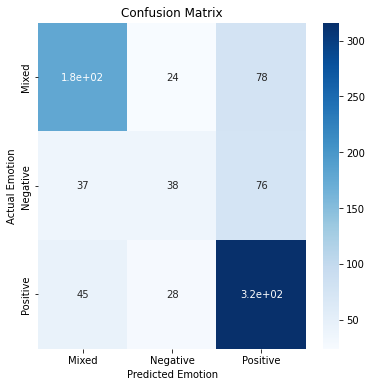

In [40]:
confusion_plt = plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, \
            xticklabels=['Mixed', 'Negative', 'Positive'], yticklabels=['Mixed', 'Negative', 'Positive'], cmap="Blues")

plt.xlabel('Predicted Emotion')
plt.ylabel('Actual Emotion')
plt.title('Confusion Matrix')

# confusion_plt.savefig("Confusion Matrix for Three Class.png", bbox_inches='tight', dpi = 250)
# files.download("Confusion Matrix for Three Class.png") 

In [41]:
print(classification_report(y_ground_truth, predicted_class_indices))

              precision    recall  f1-score   support

           0       0.69      0.64      0.66       281
           1       0.42      0.25      0.32       151
           2       0.67      0.81      0.74       389

    accuracy                           0.65       821
   macro avg       0.59      0.57      0.57       821
weighted avg       0.63      0.65      0.63       821



In [42]:
f1_score(y_ground_truth, predicted_class_indices, average = 'weighted')

0.6326747678814248

### Testing an image

Test an image for detection of emotion

In [43]:
img_height, img_width = (224, 224)

(-0.5, 1023.5, 767.5, -0.5)

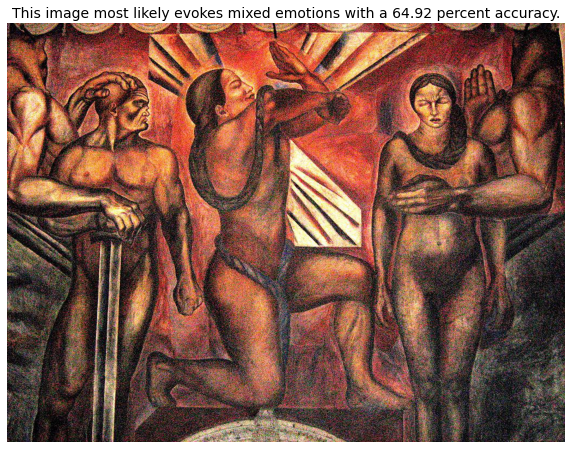

In [44]:
orozco_path = "drive/MyDrive/DL/1024px-Orozco_Mural_Omniciencia_1925_Azulejos.jpg"

img = load_img(orozco_path, target_size=(img_height, img_width))
img_array = img_to_array(img)
img_array = expand_dims(img_array, 0) 

pred = model_tc_mobilenet_aug.predict(img_array)
pred_mapped = np.argmax(pred)
predicted_emotion = class_names_list[pred_mapped]

accuracy = model_tc_mobilenet_aug.evaluate(test_generator, verbose = 0)[1]

orozco_image =  plt.figure(figsize=(10, 10))
plt.title("This image most likely evokes {} emotions with a {:.2f} percent accuracy.".format(predicted_emotion, 100 * accuracy), fontsize = 14)
plt.imshow(load_img(orozco_path))
plt.axis("off")
# orozco_image.savefig("Orozco Estimation.png", bbox_inches='tight', dpi = 250)
# files.download("Orozco Estimation.png") 

(-0.5, 3023.5, 4031.5, -0.5)

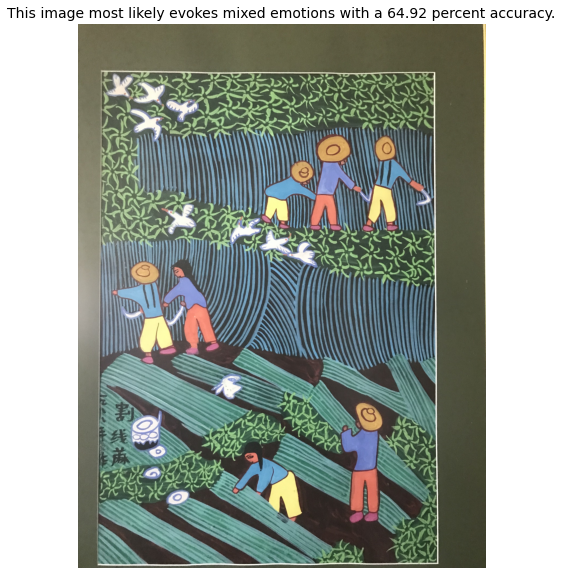

In [45]:
anonymous_path = "drive/MyDrive/DL/anonymous_art.jpg"

img = load_img(anonymous_path, target_size=(img_height, img_width))
img_array = img_to_array(img)
img_array = expand_dims(img_array, 0) 

pred = model_tc_mobilenet_aug.predict(img_array)
pred_mapped = np.argmax(pred)
predicted_emotion = class_names_list[pred_mapped]

accuracy = model_tc_mobilenet_aug.evaluate(test_generator, verbose = 0)[1]

anonymous_image =  plt.figure(figsize=(10, 10))
plt.title("This image most likely evokes {} emotions with a {:.2f} percent accuracy.".format(predicted_emotion, 100 * accuracy), fontsize = 14)
plt.imshow(load_img(anonymous_path))
plt.axis("off")
# anonymous_image.savefig("Anonymous Estimation.png", bbox_inches='tight', dpi = 250)
# files.download("Anonymous Estimation.png") 

In [46]:
def which_emotion(image_path): 
  img = load_img(image_path, target_size=(img_height, img_width))
  img_array = img_to_array(img)
  img_array = expand_dims(img_array, 0) 

  pred = model_tc_mobilenet_aug.predict(img_array)
  pred_mapped = np.argmax(pred)
  predicted_emotion = class_names_list[pred_mapped]

  accuracy = model_tc_mobilenet_aug.evaluate(test_generator, verbose = 0)[1]
  print("This image most likely evokes {} emotions with a {:.2f} percent accuracy."
      .format(predicted_emotion, 100 * accuracy))

In [47]:
which_emotion(orozco_path)

This image most likely evokes mixed emotions with a 64.92 percent accuracy.


### Figure out Wrong Predictions

In [48]:
path_names = test_generator.filenames
idx = test_generator.index_array

In [49]:
predictions_dict = {"index": idx, "path_names": path_names, "actual_emotion": y_ground_truth, "predicted_emotion": predicted_emotions}
predictions_df = pd.DataFrame(predictions_dict)
predictions_df.head(3)

index  ... predicted_emotion
0      0  ...             mixed
1      1  ...          positive
2      2  ...          positive

[3 rows x 4 columns]

In [50]:
predictions_df.actual_emotion.value_counts()

2    389
0    281
1    151
Name: actual_emotion, dtype: int64

In [51]:
predictions_df.actual_emotion = predictions_df.actual_emotion.apply(lambda x: "negative" if (x ==1) else ("positive" if (x==2) else "mixed" ))
predictions_df.head(3)

index  ... predicted_emotion
0      0  ...             mixed
1      1  ...          positive
2      2  ...          positive

[3 rows x 4 columns]

In [52]:
predictions_df.actual_emotion.value_counts()

positive    389
mixed       281
negative    151
Name: actual_emotion, dtype: int64

In [53]:
wrong_predictions = (predictions_df[predictions_df.actual_emotion != predictions_df.predicted_emotion])
wrong_predictions

index  ... predicted_emotion
1        1  ...          positive
5        5  ...          negative
6        6  ...          negative
7        7  ...          positive
8        8  ...          positive
..     ...  ...               ...
806    806  ...             mixed
808    808  ...             mixed
809    809  ...          negative
815    815  ...             mixed
817    817  ...          positive

[288 rows x 4 columns]

In [54]:
wrong_predictions.predicted_emotion.value_counts()

positive    154
mixed        82
negative     52
Name: predicted_emotion, dtype: int64

In [55]:
wrong_predictions.actual_emotion.value_counts()

negative    113
mixed       102
positive     73
Name: actual_emotion, dtype: int64

Predicted: positive. Actual: mixed.


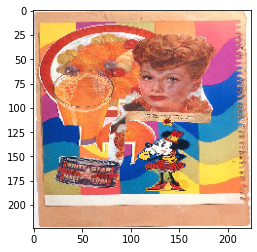

In [56]:
img = load_img(wrong_predictions.iloc[0, 1], target_size=(img_height, img_width))
plt.imshow(img)
print(f"Predicted: {wrong_predictions.iloc[0, 3]}. Actual: {wrong_predictions.iloc[0, 2]}.")

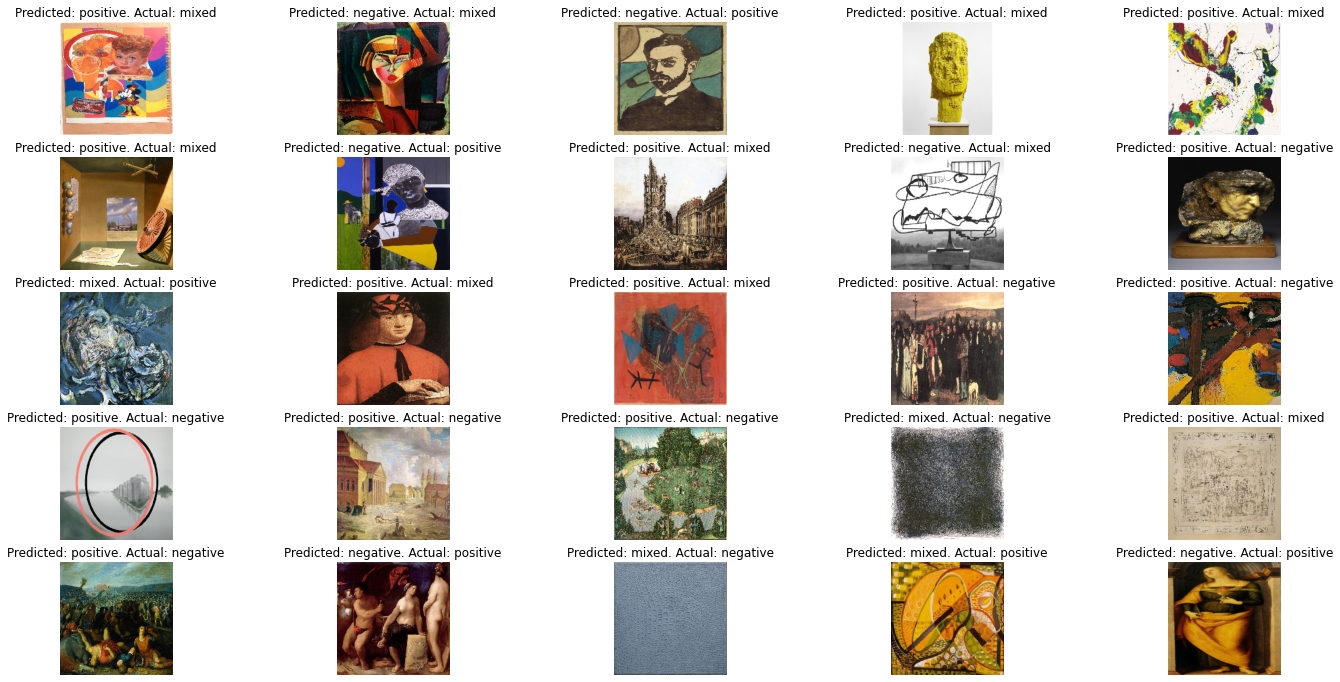

In [57]:
images_plt = plt.figure(figsize=(24, 12))
for i in range(25): 
  ax = plt.subplot(5, 5, i + 1)
  img = load_img(wrong_predictions.iloc[i, 1], target_size=(img_height, img_width))
  plt.imshow(img)
  plt.title('Predicted: {0}. Actual: {1}'.format(wrong_predictions.iloc[i, 3], wrong_predictions.iloc[i, 2]), fontsize = 12)
  plt.axis("off")

images_plt.show()

# images_plt.savefig("Three_Classes_Model_Images_25.png", bbox_inches='tight', dpi = 250)
# files.download("Three_Classes_Model_Images_25.png") 

### Confusion Matrix & Wrong Predictions DataFrame Combined

1. Predicted: Positive. Actual: Negative. (80 of them)
2. Predicted: Positive. Actual: Mixed. (54 of them) 
3. Predicted: Negative. Actual: Positive. (14 of them)
4. Predicted: Negative. Actual: Mixed. (11 of them) 
5. Predicted: Mixed. Actual: Positive. (61 of them) 
6. Predicted: Mixed. Actual: Negative. (44)

Total test images: 821. 



In [58]:
# First category
actual_neg_predicted_pos = wrong_predictions[(wrong_predictions.actual_emotion == "negative") & (wrong_predictions.predicted_emotion == "positive")]
actual_neg_predicted_pos.head(5)

index  ... predicted_emotion
16     16  ...          positive
29     29  ...          positive
38     38  ...          positive
40     40  ...          positive
43     43  ...          positive

[5 rows x 4 columns]

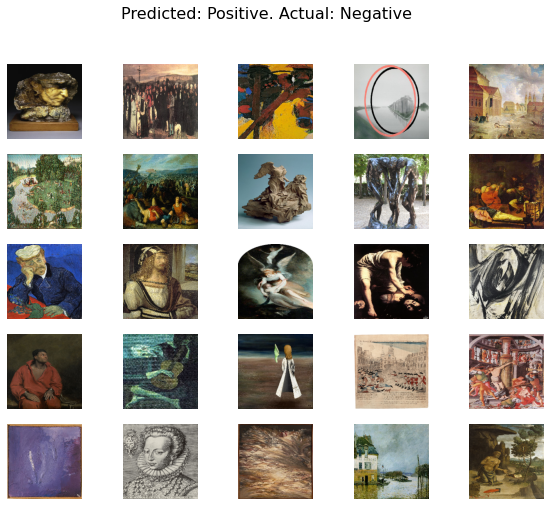

In [59]:
ac_neg_pred_pos_images_plt = plt.figure(figsize=(10, 8))
for i in range(25): 
  ax = plt.subplot(5, 5, i + 1)
  img = load_img(actual_neg_predicted_pos.iloc[i, 1], target_size=(img_height, img_width))
  plt.imshow(img)
  plt.axis("off")

ac_neg_pred_pos_images_plt.suptitle('Predicted: Positive. Actual: Negative', fontsize=16)
ac_neg_pred_pos_images_plt.show()
# ac_neg_pred_pos_images_plt.savefig("Predicted: Positive. Actual: Negative 16.png", bbox_inches='tight', dpi = 250)
# files.download("Predicted: Positive. Actual: Negative 16.png") 

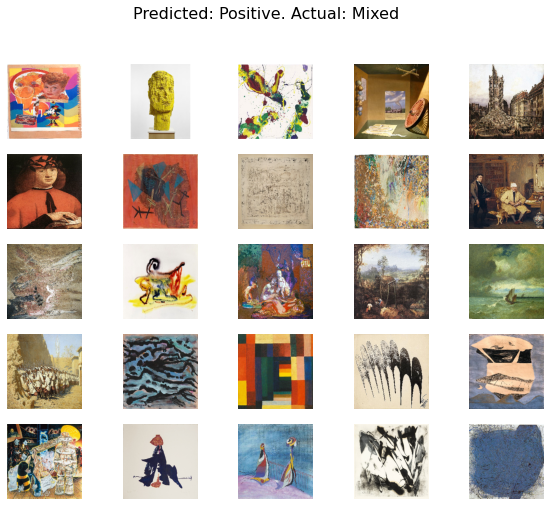

In [60]:
## 2. Predicted: Positive. Actual: Mixed. (54 of them)
actual_mix_predicted_pos = wrong_predictions[(wrong_predictions.actual_emotion == "mixed") & (wrong_predictions.predicted_emotion == "positive")]

ac_mix_pred_pos_images_plt = plt.figure(figsize=(10, 8))
for i in range(25): 
  ax = plt.subplot(5, 5, i + 1)
  img = load_img(actual_mix_predicted_pos.iloc[i, 1], target_size=(img_height, img_width))
  plt.imshow(img)
  plt.axis("off")

ac_mix_pred_pos_images_plt.suptitle('Predicted: Positive. Actual: Mixed', fontsize=16)
ac_mix_pred_pos_images_plt.show()
# ac_mix_pred_pos_images_plt.savefig("Predicted: Positive. Actual: Mixed 54.png", bbox_inches='tight', dpi = 250)
# files.download("Predicted: Positive. Actual: Mixed 54.png") 

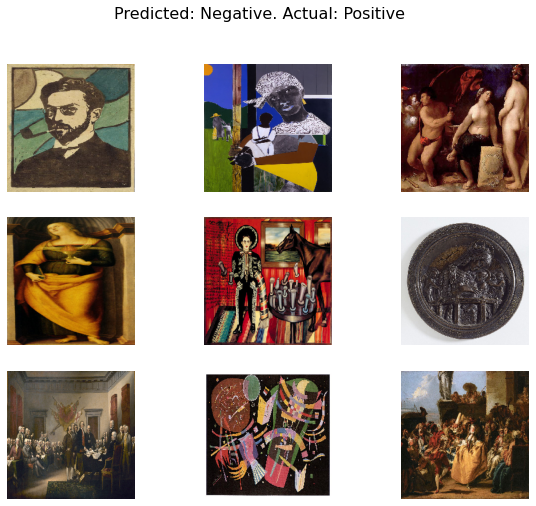

In [61]:
## 3. Predicted: Negative. Actual: Positive. (14 of them)
actual_pos_predicted_neg = wrong_predictions[(wrong_predictions.actual_emotion == "positive") & (wrong_predictions.predicted_emotion == "negative")]
ac_pos_pred_neg_images_plt = plt.figure(figsize=(10, 8))
for i in range(9): 
  ax = plt.subplot(3, 3, i + 1)
  img = load_img(actual_pos_predicted_neg.iloc[i, 1], target_size=(img_height, img_width))
  plt.imshow(img)
  plt.axis("off")

ac_pos_pred_neg_images_plt.suptitle('Predicted: Negative. Actual: Positive', fontsize=16)
ac_pos_pred_neg_images_plt.show()
# ac_pos_pred_neg_images_plt.savefig("Predicted: Negative. Actual: Positive 14.png", bbox_inches='tight', dpi = 250)
# files.download("Predicted: Negative. Actual: Positive 14.png") 

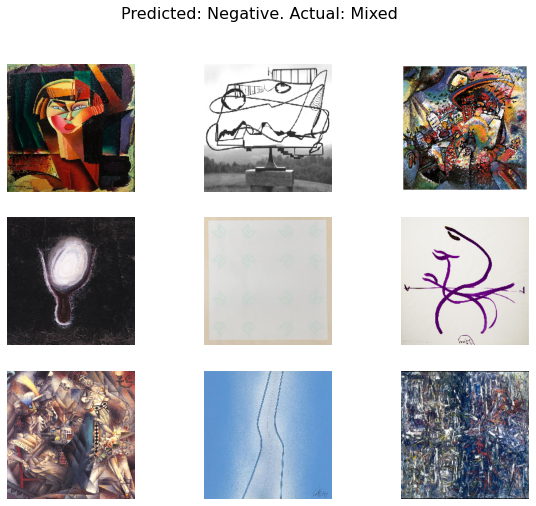

In [62]:
## 4. Predicted: Negative. Actual: Mixed. (11 of them)
actual_mixed_predicted_neg = wrong_predictions[(wrong_predictions.actual_emotion == "mixed") & (wrong_predictions.predicted_emotion == "negative")]
ac_mix_pred_neg_images_plt = plt.figure(figsize=(10, 8))
for i in range(9): 
  ax = plt.subplot(3, 3, i + 1)
  img = load_img(actual_mixed_predicted_neg.iloc[i, 1], target_size=(img_height, img_width))
  plt.imshow(img)
  plt.axis("off")

ac_mix_pred_neg_images_plt.suptitle('Predicted: Negative. Actual: Mixed', fontsize=16)
ac_mix_pred_neg_images_plt.show()
# ac_mix_pred_neg_images_plt.savefig("Predicted: Negative. Actual: Mixed 11.png", bbox_inches='tight', dpi = 250)
# files.download("Predicted: Negative. Actual: Mixed 11.png") 

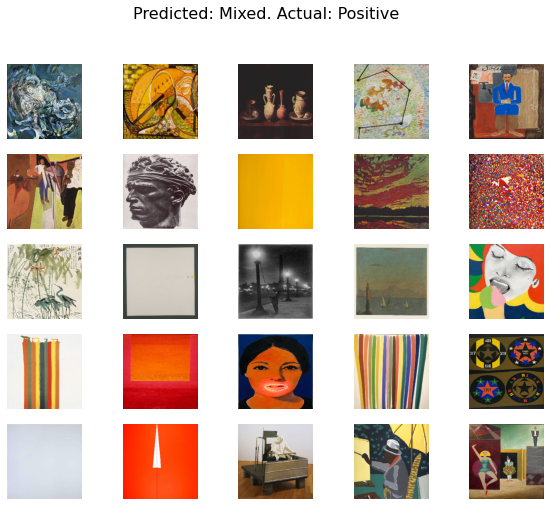

In [63]:
## 5. Predicted: Mixed. Actual: Positive. (61 of them)
actual_mixed_predicted_pos = wrong_predictions[(wrong_predictions.actual_emotion == "positive") & (wrong_predictions.predicted_emotion == "mixed")]
ac_mix_pred_pos_images_plt = plt.figure(figsize=(10, 8))
for i in range(25): 
  ax = plt.subplot(5, 5, i + 1)
  img = load_img(actual_mixed_predicted_pos.iloc[i, 1], target_size=(img_height, img_width))
  plt.imshow(img)
  plt.axis("off")

ac_mix_pred_pos_images_plt.suptitle('Predicted: Mixed. Actual: Positive', fontsize=16)
ac_mix_pred_pos_images_plt.show()
# ac_mix_pred_pos_images_plt.savefig("Predicted: Mixed. Actual: Positive 61.png", bbox_inches='tight', dpi = 250)
# files.download("Predicted: Mixed. Actual: Positive 61.png") 

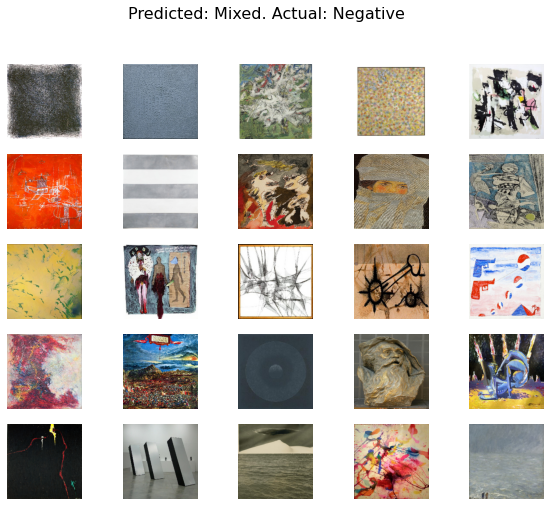

In [64]:
## 6. Predicted: Mixed. Actual: Negative. (44)
actual_neg_predicted_mixed = wrong_predictions[(wrong_predictions.actual_emotion == "negative") & (wrong_predictions.predicted_emotion == "mixed")]
ac_neg_pred_mix_images_plt = plt.figure(figsize=(10, 8))
for i in range(25): 
  ax = plt.subplot(5, 5, i + 1)
  img = load_img(actual_neg_predicted_mixed.iloc[i, 1], target_size=(img_height, img_width))
  plt.imshow(img)
  plt.axis("off")

ac_neg_pred_mix_images_plt.suptitle('Predicted: Mixed. Actual: Negative', fontsize=16)
ac_neg_pred_mix_images_plt.show()
# ac_neg_pred_mix_images_plt.savefig("Predicted: Mixed. Actual: Negative 44.png", bbox_inches='tight', dpi = 250)
# files.download("Predicted: Mixed. Actual: Negative 44.png") 